# Tutorial overview
This notebook provides a demo of how to use ```insilicoSV``` to create a synthetic genome with structural variants (SVs), simulate short and long reads from this genome, align the resulting reads to the input reference, and inspect the results. 

The demo YAML config file specifying what SVs to simulate is provided here: ```configs/demo_config.yaml```. This demo uses chr21 of GRCh38 (download instructions provided below) as the input reference, ```DWGSIM``` for short-read and ```PBSIM3``` for long-read simulation, respectively, ```minimap2``` for read alignment, and ```samplot``` for SV visualization. 

All the required dependencies for this notebook can be installed using conda as follows:

```$> conda env create --file install/insilicosv_notebook_demo.yml```  

```$> conda activate insilicosv_notebook_demo```

```$> pip install -e .```

## Genome simulation
Set up the demo output folder and the necessary input files (reference genome and YAML config).

The demo YAML config file includes 5 different SV categories: deletions (DEL), tandem duplications (DUP), inversions (INV), inverted duplications (```A->aa``` given in grammatical form), and a custom complex event ```AB->AbbA```. Each category specifies 5 events to be simulated in the range of 5000-10000bp.

In [ ]:
%%sh
mkdir -p demo

# download the chr21 reference
wget -O demo/chr21.fa.gz https://hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/chr21.fa.gz
gunzip -f demo/chr21.fa.gz

In [ ]:
%%sh

# copy the YAML config file
cp ./configs/demo_config.yaml demo/.

# display the config
cat demo/demo_config.yaml

Run `insilicosv` with the demo config as input.

In [56]:
%%sh
insilicosv -c demo/demo_config.yaml

2025-04-04 13:42:34,474 INFO insilicoSV version v2.0.0
2025-04-04 13:42:34,477 INFO Constructing SVs from 5 categories
2025-04-04 13:42:34,479 INFO Constructed 25 SVs
2025-04-04 13:42:34,479 INFO Deciding placement order for 25 SVs
2025-04-04 13:42:34,479 INFO Placing 25 svs
2025-04-04 13:42:34,487 INFO Placed 25 svs in 0.0s.
2025-04-04 13:42:34,488 INFO Writing outputs
2025-04-04 13:42:34,488 INFO Writing VCF file
2025-04-04 13:42:34,492 INFO Writing new haplotypes
2025-04-04 13:42:35,552 INFO Writing novel insertions file
2025-04-04 13:42:35,554 INFO Output path: demo
2025-04-04 13:42:35,554 INFO insilicoSV finished in 1.1s


Show the output VCF generated from the simulation.

In [ ]:
%%sh
cat demo/sim.vcf

## Read simulation
### Short-read simulation
Below we combine the two haplotypes of the simulated genome into a single FASTA file and simulate paired-end short reads at 10x coverage using ```DWGSIM```. 

In [ ]:
%%sh
cat demo/sim.hapA.fa demo/sim.hapB.fa > demo/sim.fa

GENOME=demo/sim.fa
OUTPUT_PREFIX=demo/sim_sr.dwgsim
COVERAGE=5
READ_LEN=151
PLATFORM=0  # Illumina
dwgsim -C ${COVERAGE} -1 ${READ_LEN} -2 ${READ_LEN} -o ${PLATFORM} -H ${GENOME} ${OUTPUT_PREFIX}

After generating the reads, we align them with minimap2 (short-read mode) and sort the alignments using ```samtools```.

In [ ]:
%%sh
REF=demo/chr21.fa
R1=demo/sim_sr.dwgsim.bwa.read1.fastq.gz
R2=demo/sim_sr.dwgsim.bwa.read2.fastq.gz
minimap2 -ax sr $REF $R1 $R2 | samtools sort -o demo/sim.illumina.minimap2.sorted.bam -
samtools index demo/sim.illumina.minimap2.sorted.bam
samtools coverage demo/sim.illumina.minimap2.sorted.bam > demo/sim.illumina.minimap2.sorted.bam.coverage

In [57]:
%%sh
cat demo/sim.illumina.minimap2.sorted.bam.coverage

#rname	startpos	endpos	numreads	covbases	coverage	meandepth	meanbaseq	meanmapq
chr21	1	46709983	3073337	40069637	85.7839	9.93023	17.4	54.5


### Long-read simulation
We use PBSIM3 to simulate HiFi reads from the synthetic genome (again at 10x coverage). Since PBSIM3 outputs reads for each reference contig, we also combine the reads from the two synthetic haplotypes into a single FASTQ file.

In [ ]:
%%sh
GENOME=demo/sim.fa
OUTPUT_PREFIX=demo/sim_lr.pbsim
COVERAGE=5
rm demo/sim_lr.pbsim*
pbsim --depth ${COVERAGE} --genome ${GENOME} --prefix ${OUTPUT_PREFIX} --strategy wgs --method qshmm --qshmm ${CONDA_PREFIX}/data/QSHMM-RSII.model --length-mean 20000 --accuracy-mean 0.999
zcat demo/sim_lr.pbsim*.fq.gz >> demo/sim_lr.pbsim.fastq

After generating the reads, we align them with minimap2 (HiFi mode) and sort the alignments using ```samtools```.

In [ ]:
%%sh
REF=demo/chr21.fa
READS=demo/sim_lr.pbsim.fastq
minimap2 -ax map-hifi $REF $READS | samtools sort -o demo/sim.hifi.minimap2.sorted.bam -
samtools index demo/sim.hifi.minimap2.sorted.bam

## SV Visualization
Below we generate ```samplot``` illustrations for each SV simulated with ```insilicoSV```.

In [ ]:
%%sh
mkdir -p demo/samplot

In [ ]:
from pysam import VariantFile
from IPython.display import Image
from collections import defaultdict
import os
os.environ["MPLBACKEND"] = "Agg"

vcf_path = "demo/sim.vcf"
short_read_bam = "demo/sim.illumina.minimap2.sorted.bam"
long_read_bam = "demo/sim.hifi.minimap2.sorted.bam"
output_path = "demo/samplot/"

vcf = VariantFile(vcf_path)
rec2breakends = defaultdict(set)
for vcf_rec in vcf.fetch():
    vcf_info = dict(vcf_rec.info)        
    sv_title = "%s_%s_%s" % (vcf_info['PARENT_SVTYPE'], 
                             vcf_info['PARENT_SVID'], 
                             vcf_info['GRAMMAR'].replace("->", "-to-"))
    rec2breakends[sv_title].add(vcf_rec.start)
    rec2breakends[sv_title].add(vcf_rec.stop)
    if 'TARGET' in vcf_info:
        rec2breakends[sv_title].add(vcf_info['TARGET'])
vcf.close()
           
for sv_title, sv_breakends in rec2breakends.items():
    sv_breakends = sorted(sv_breakends)
    output_file = "%s/%s.png" % (output_path, sv_title)
    start = min(sv_breakends)
    end = max(sv_breakends)
    wlen = end - start + 1000
    cmd = "samplot plot -n Illumina HiFi -b %s %s -s %s -e %s -c chr21 -t %s -w %d" \
          " --include_mqual 0 --separate_mqual 1 -o %s" % (short_read_bam, long_read_bam, 
                                                           start, end, sv_title, wlen, output_file)
    print(cmd)
    os.system(cmd)

In [ ]:
%%sh
ls -l demo/samplot/

We visualize each SV type below.

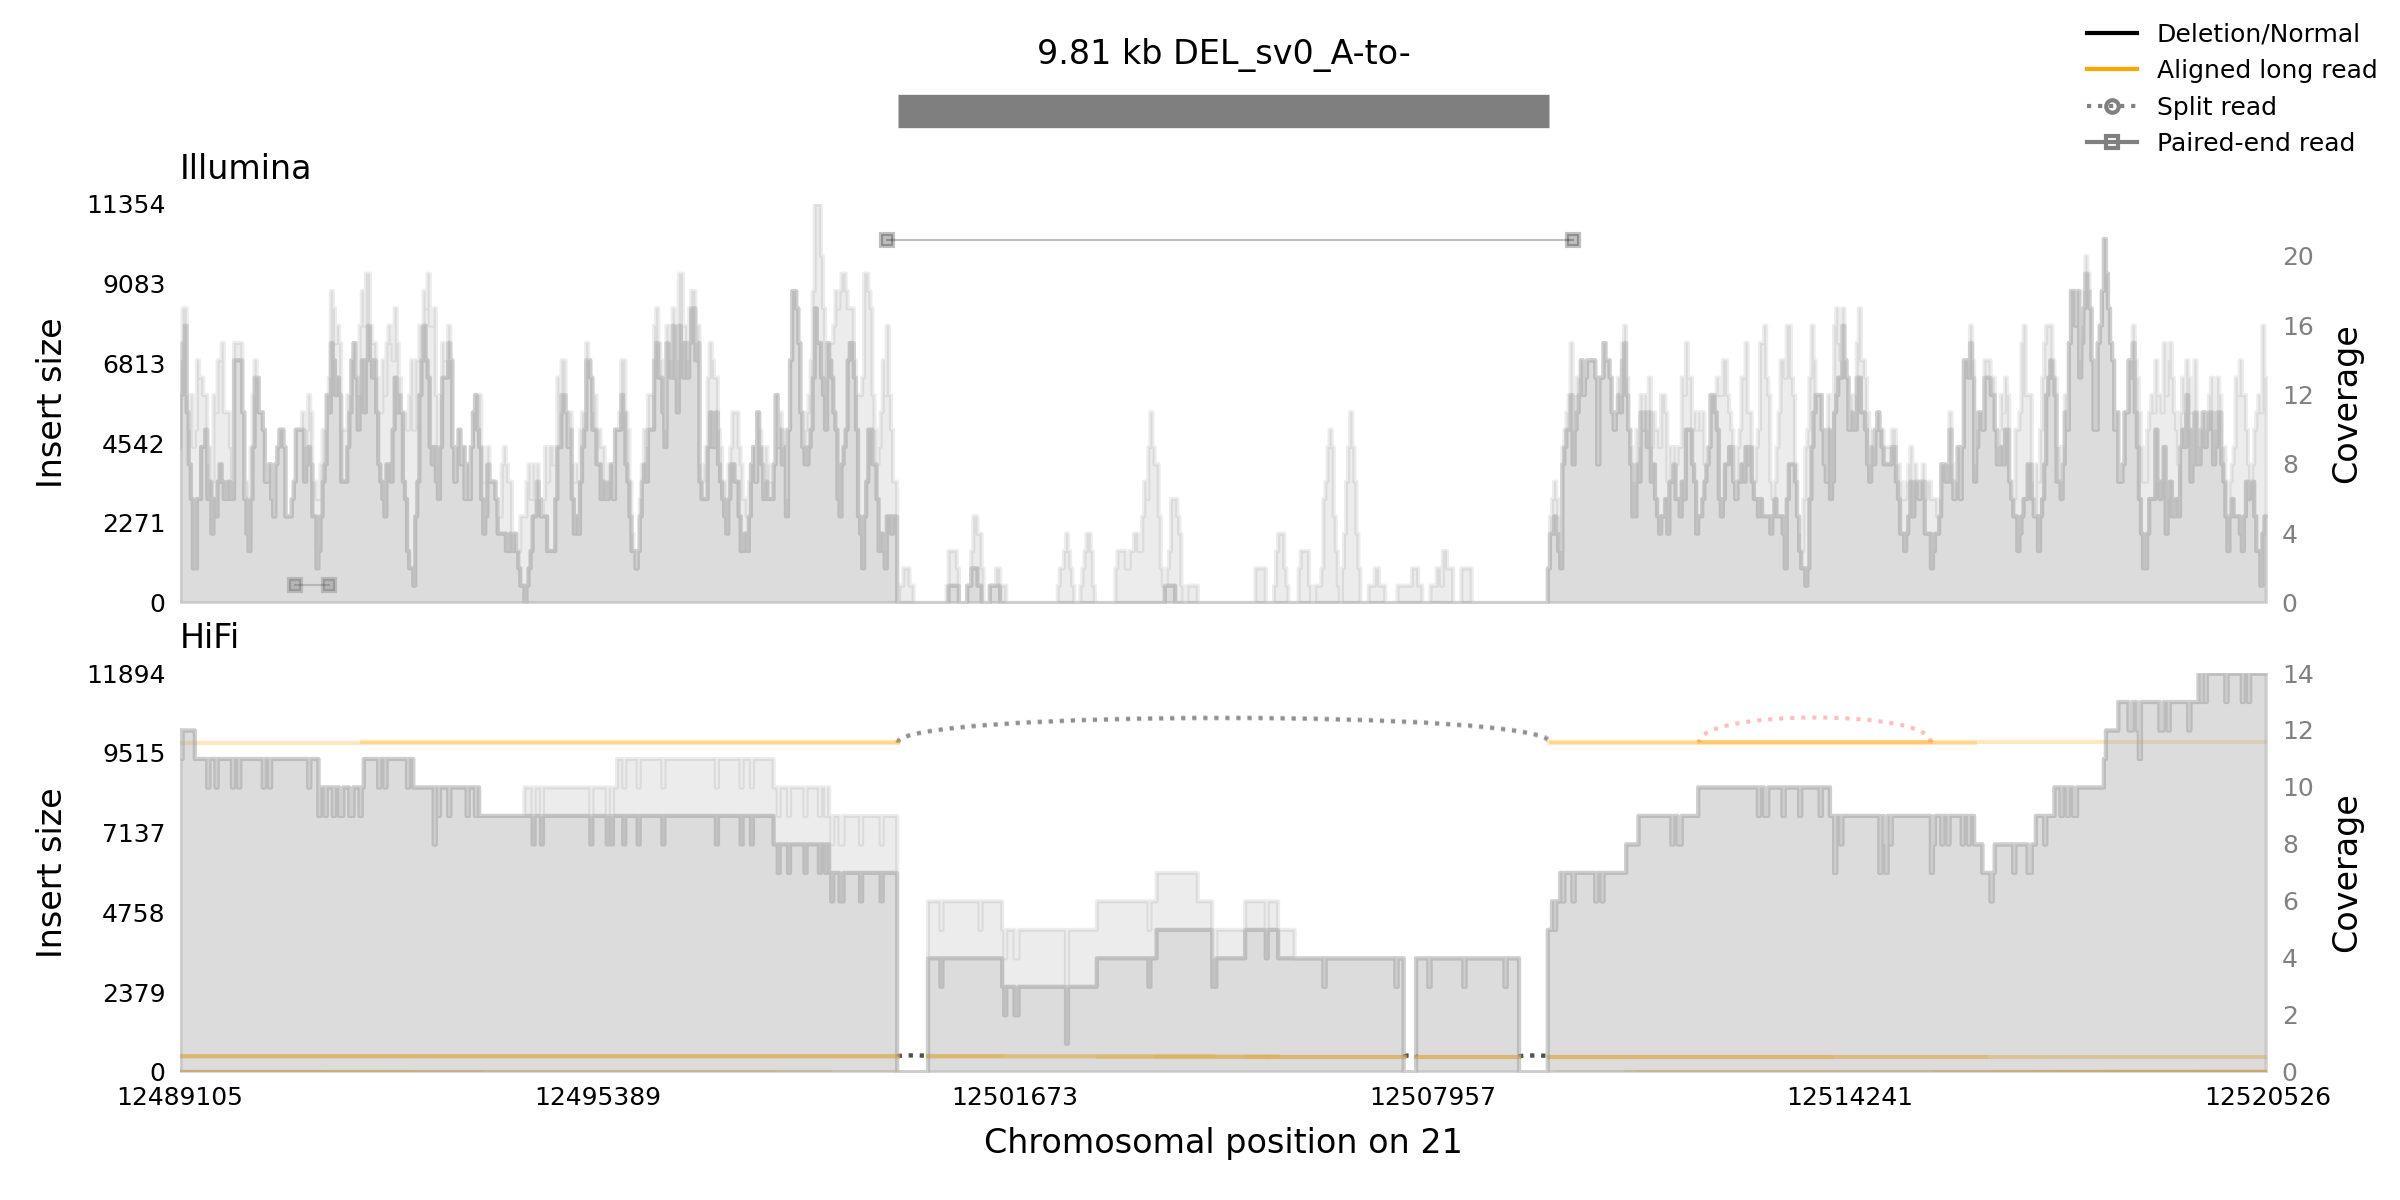

In [58]:
Image(filename='demo/samplot/DEL_sv0_A-to-.png')

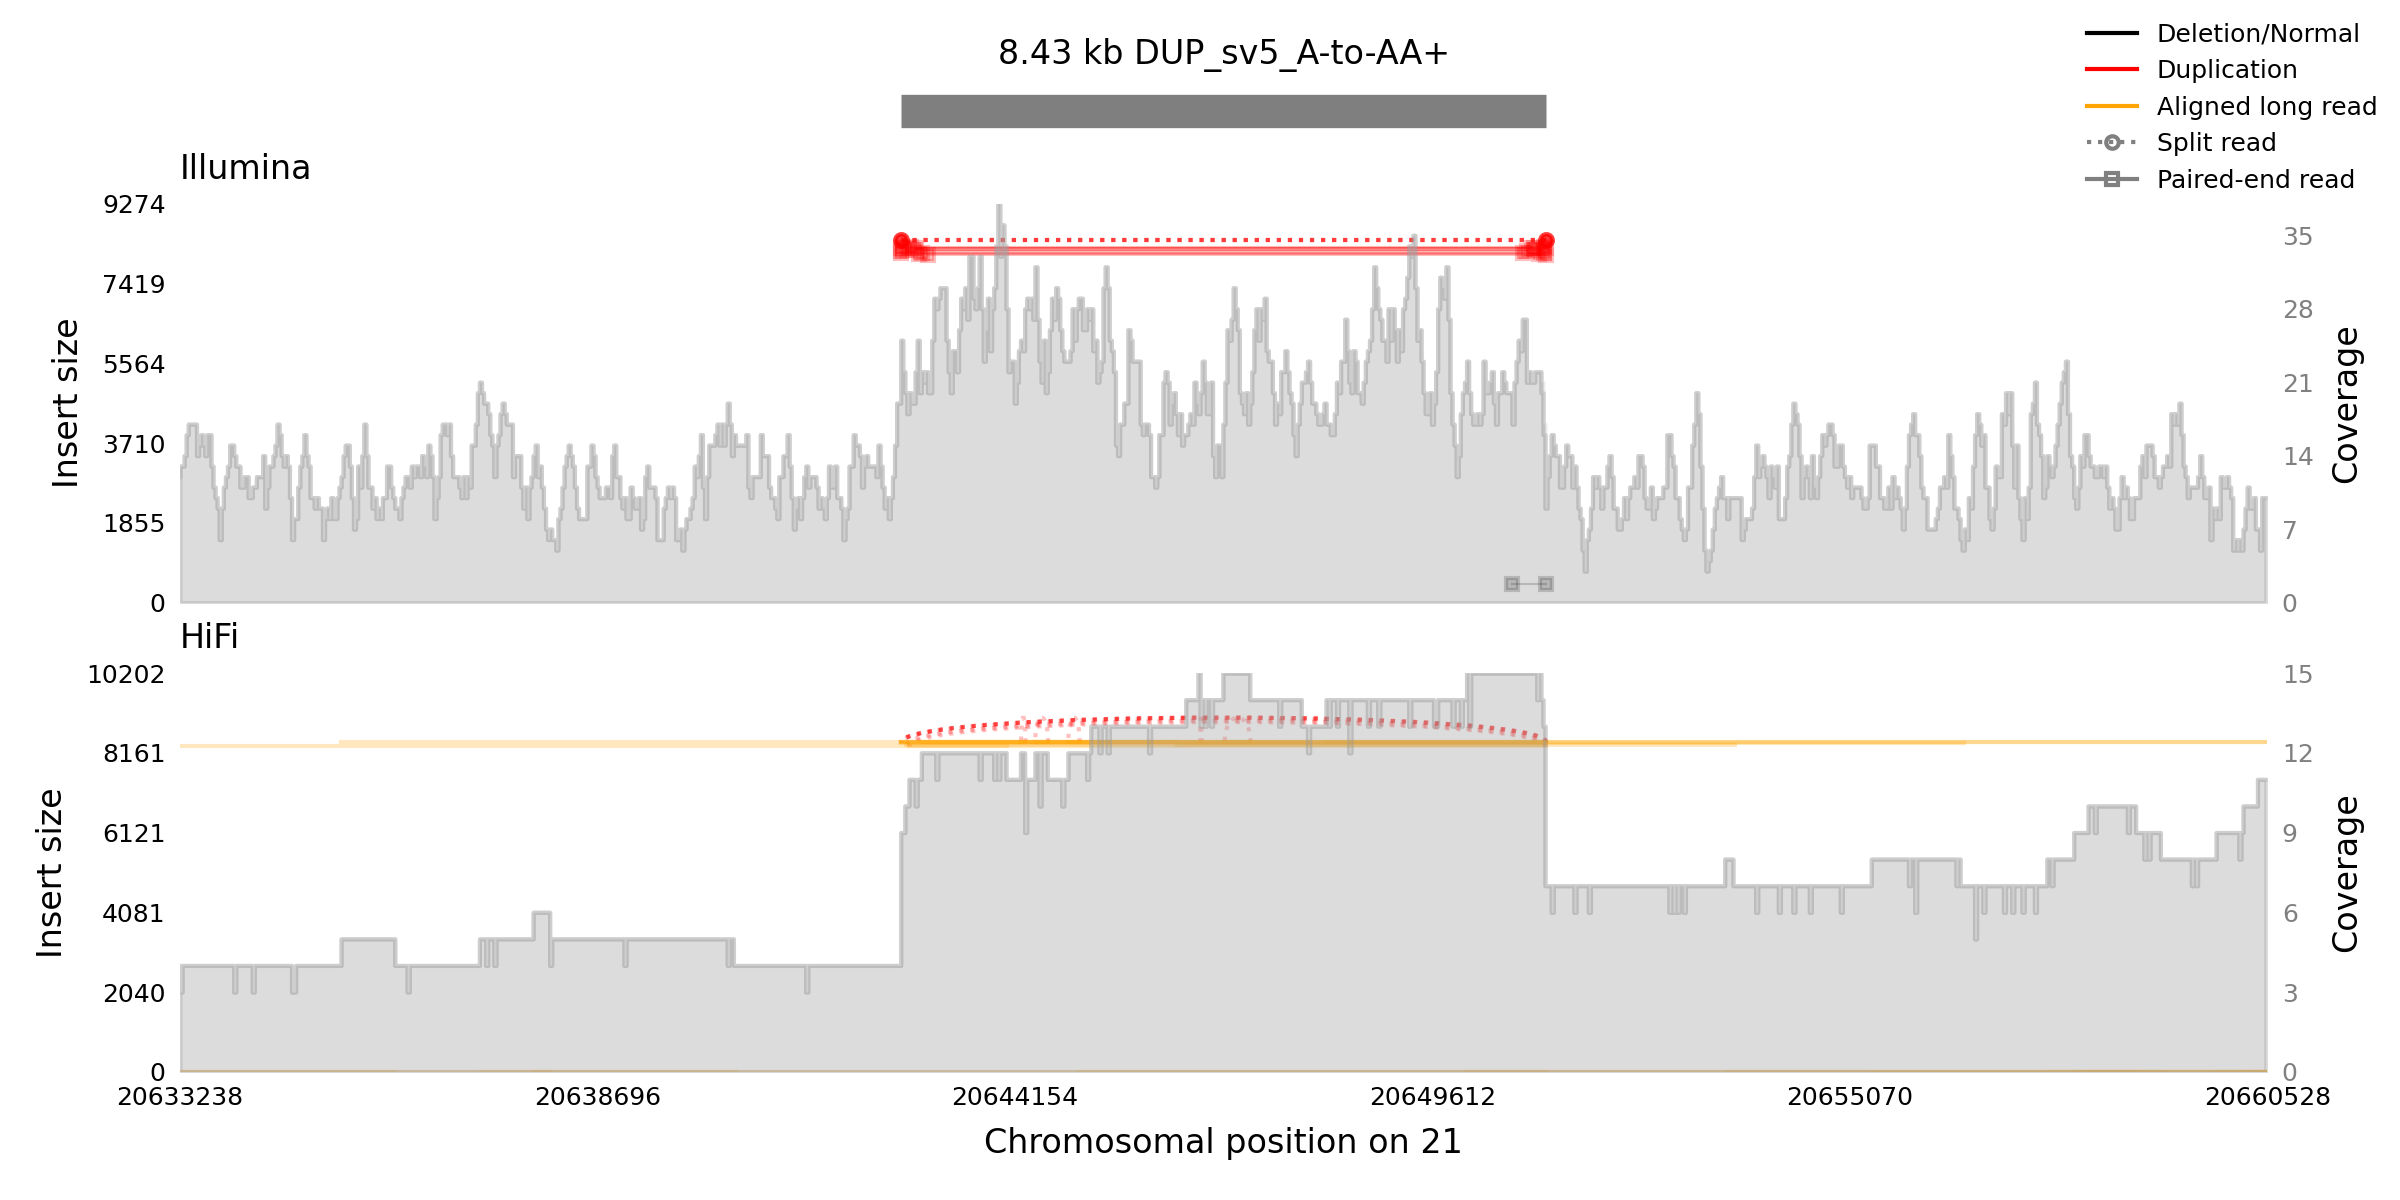

In [59]:
Image(filename='demo/samplot/DUP_sv5_A-to-AA+.png')

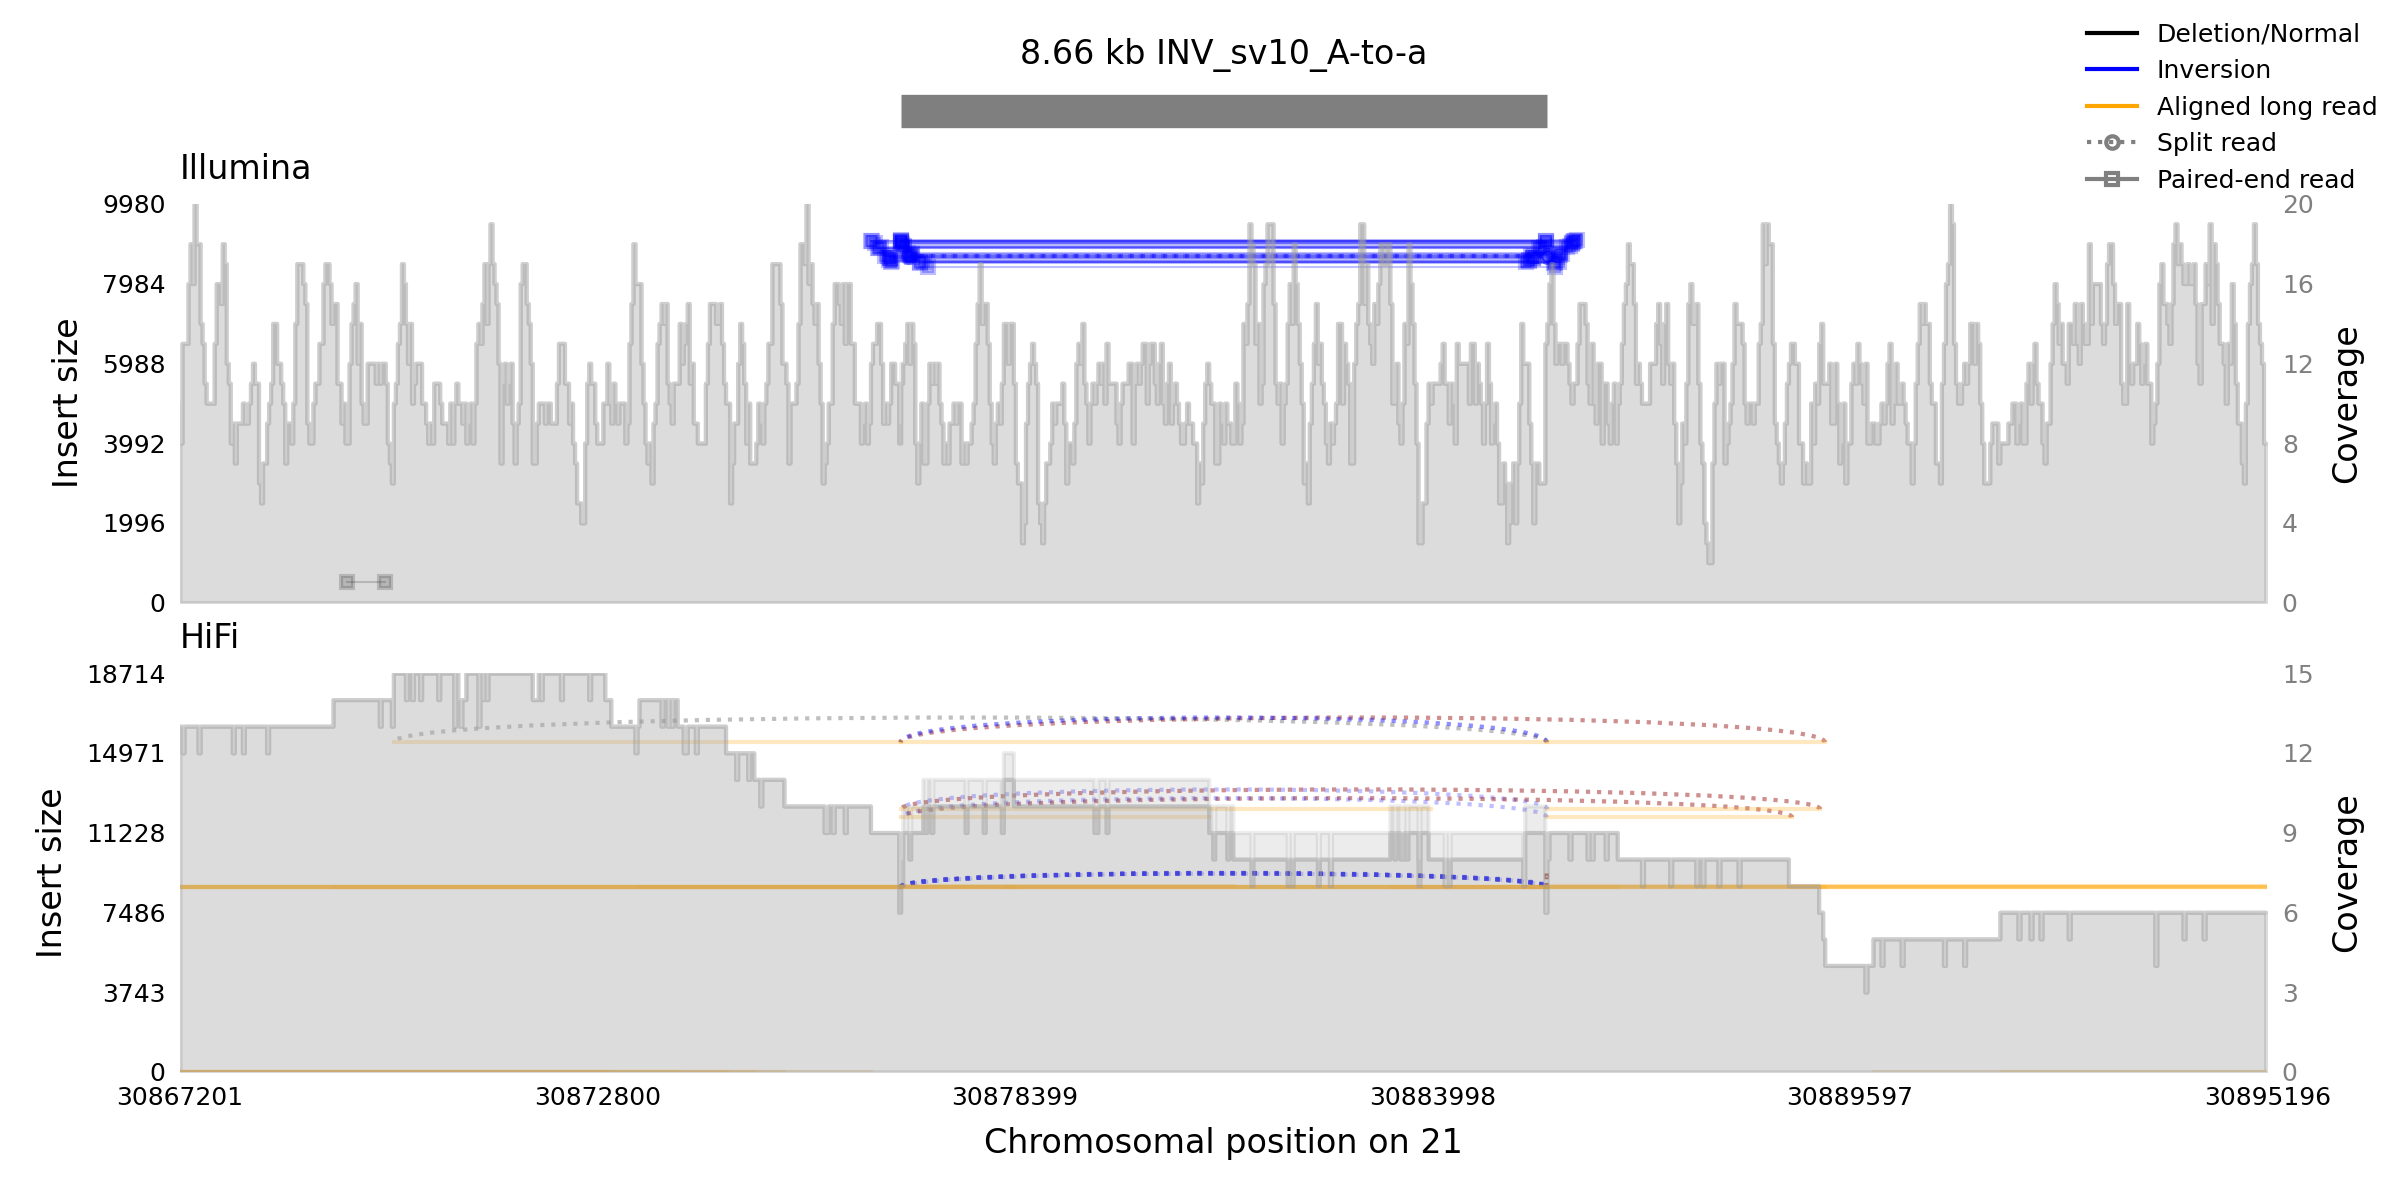

In [60]:
Image(filename='demo/samplot/INV_sv10_A-to-a.png')

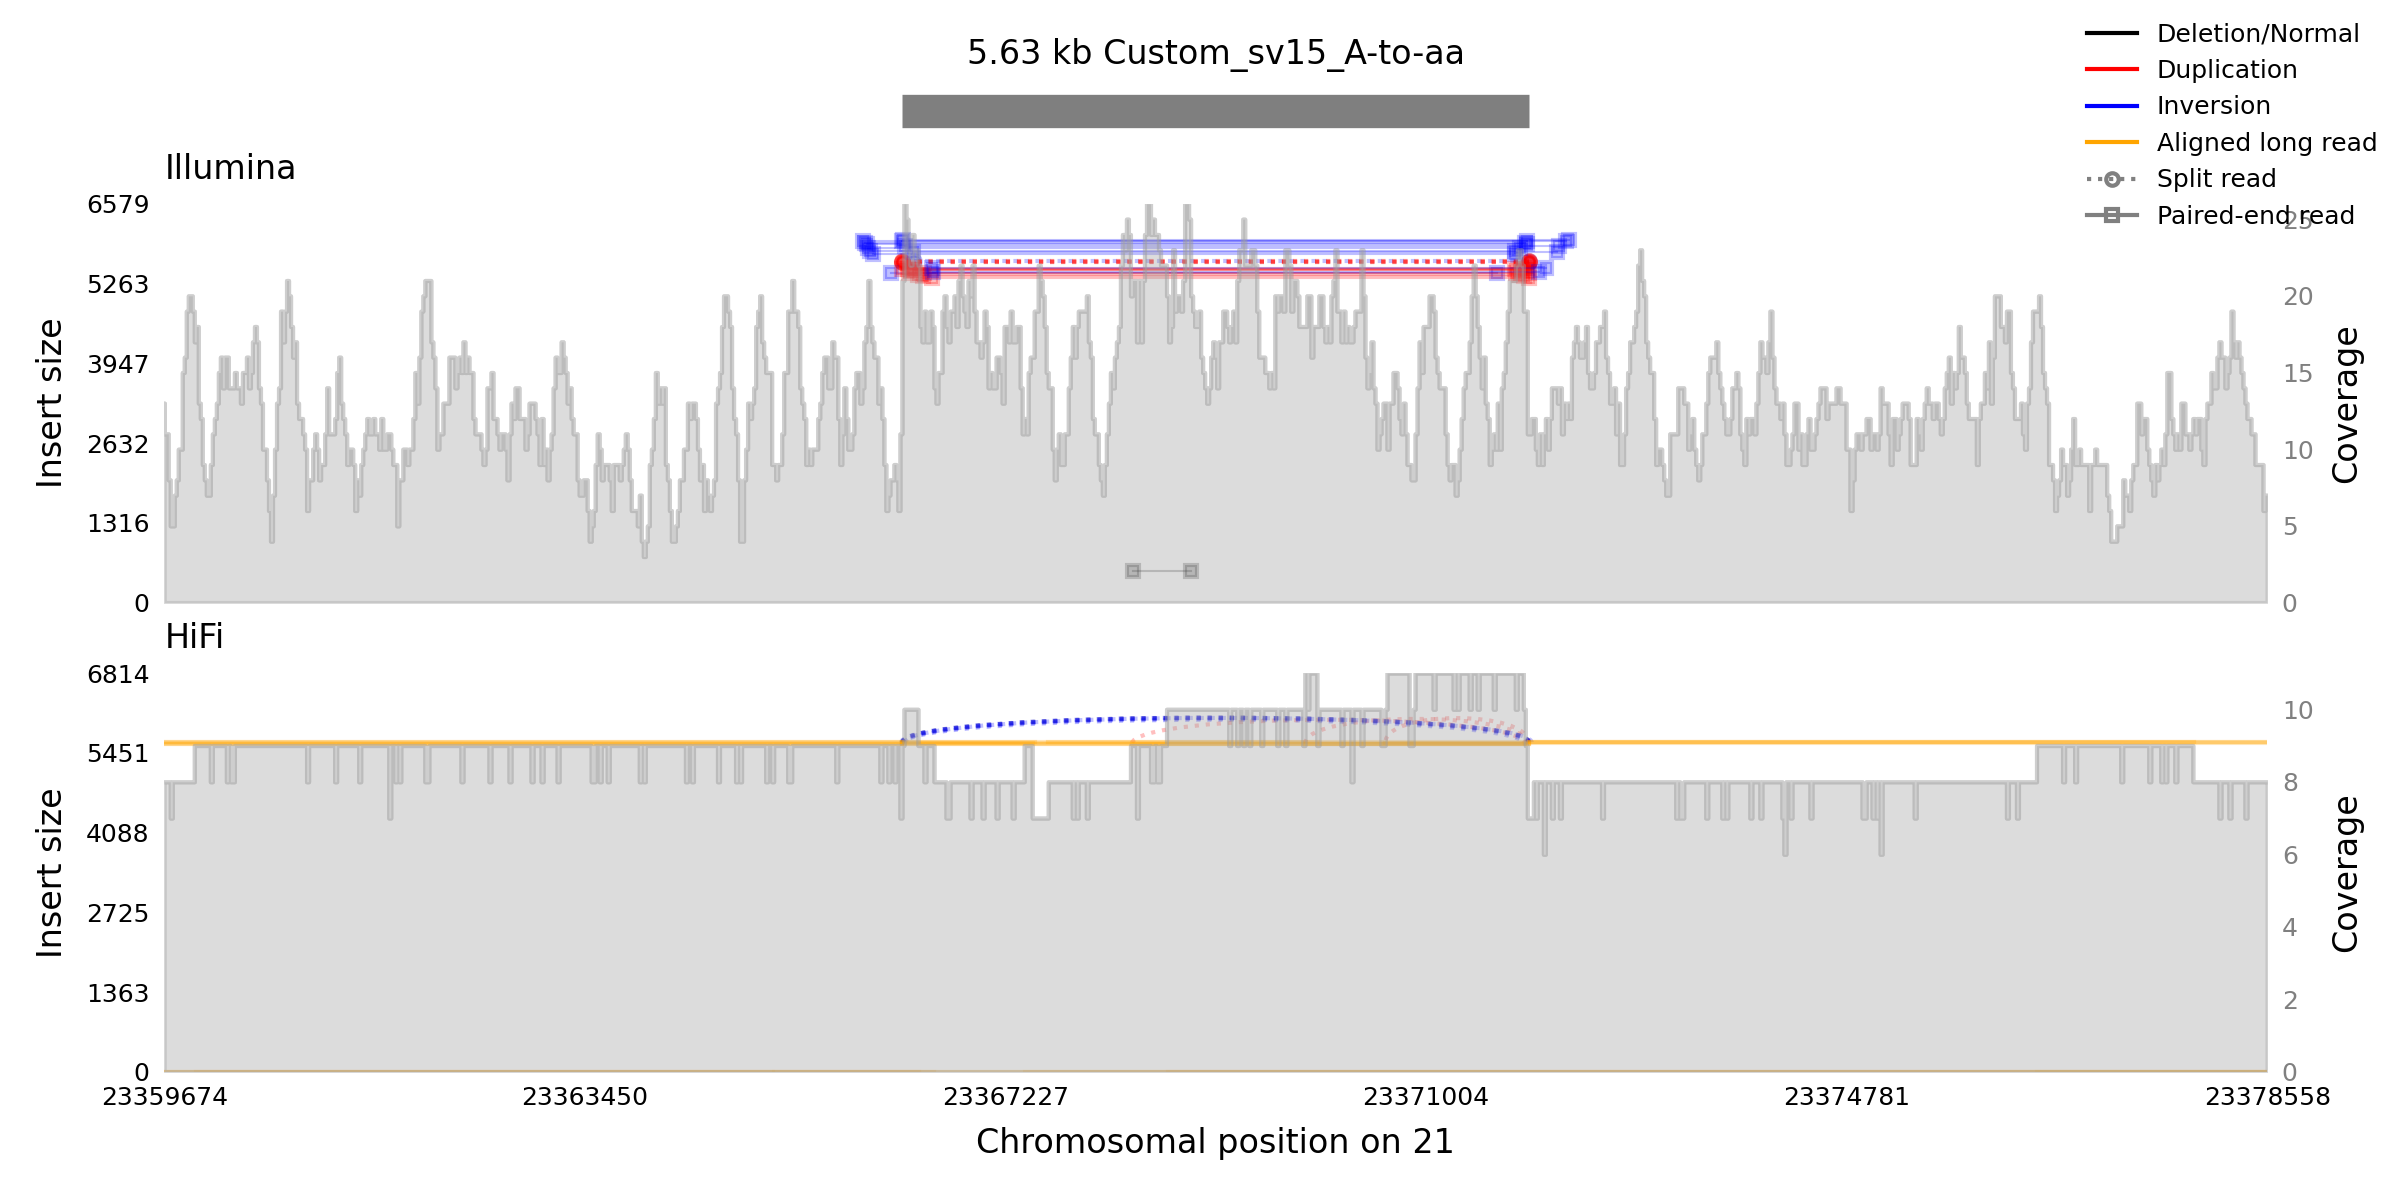

In [61]:
Image(filename='demo/samplot/Custom_sv15_A-to-aa.png')

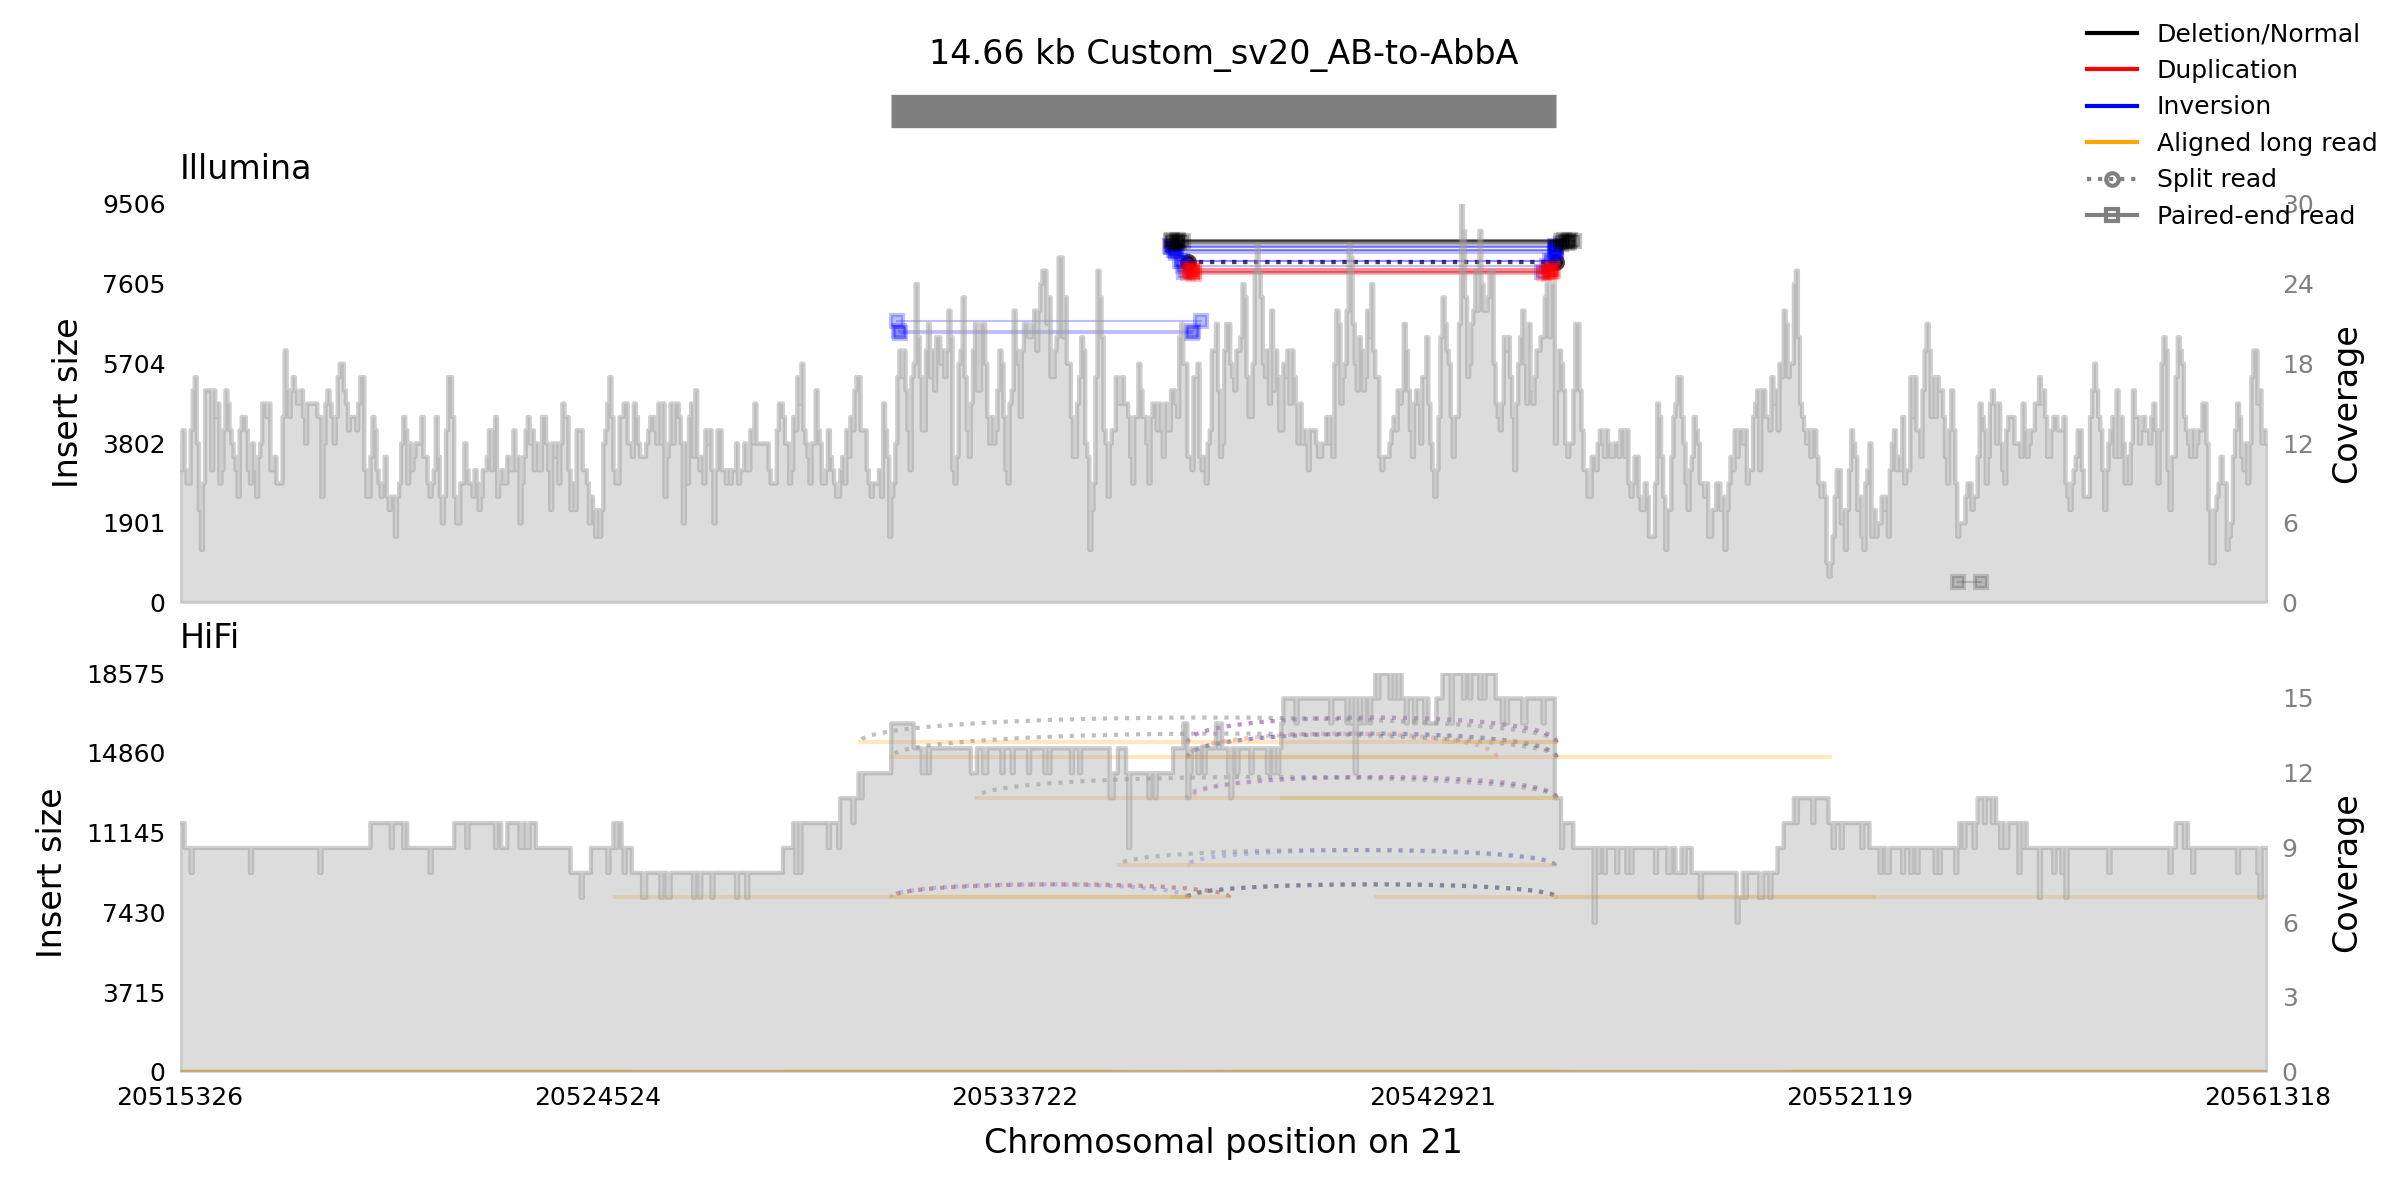

In [62]:
Image(filename='demo/samplot/Custom_sv20_AB-to-AbbA.png')